In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Load the dataset
all_stocks_df = pd.read_csv('/content/Stocks/all_stocks_less_years.csv')

# Function to preprocess stock data
def preprocess_stock_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', 'Close']]
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['Close'] = scaler.fit_transform(df[['Close']])
    df.index = df.pop('Date')
    return df, scaler

# Function to create windowed dataset
def df_to_windowed_df(dataframe, n=3):
    dates, X, Y = [], [], []
    for i in range(len(dataframe) - n):
        x = dataframe['Close'].iloc[i:i+n].values
        y = dataframe['Close'].iloc[i+n]
        dates.append(dataframe.index[i+n])
        X.append(x)
        Y.append(y)
    return np.array(dates), np.array(X).reshape(-1, n, 1), np.array(Y)

# Function to train model
def train_model(X_train, y_train, X_val, y_val):
    model = Sequential([
        layers.Input((X_train.shape[1], 1)),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=0)
    return model

# Function to predict future steps
def predict_future(model, initial_window, steps=1370):
    predictions = []
    current_window = initial_window
    for _ in range(steps):
        next_prediction = model.predict(current_window[np.newaxis, :, :])[0, 0]
        predictions.append(next_prediction)
        current_window = np.roll(current_window, -1)
        current_window[-1] = next_prediction
    return predictions

# Process each stock individually
results = []
for stock, stock_df in all_stocks_df.groupby('Index'):
    print(f"Processing stock: {stock}")
    stock_df, scaler = preprocess_stock_data(stock_df)
    dates, X, Y = df_to_windowed_df(stock_df)

    q_80 = int(len(dates) * 0.8)
    q_90 = int(len(dates) * 0.9)
    X_train, y_train = X[:q_80], Y[:q_80]
    X_val, y_val = X[q_80:q_90], Y[q_80:q_90]
    X_test, y_test = X[q_90:], Y[q_90:]

    model = train_model(X_train, y_train, X_val, y_val)

    # Predict 1370 future days
    future_predictions = predict_future(model, X_test[-1], steps=1370)
    future_dates = pd.date_range(start=dates[-1], periods=1370, freq='D')

    for date, pred in zip(future_dates, future_predictions):
        results.append({'Stock': stock, 'Date': date, 'Actual': None, 'Prediction': pred})

# Save results to a single CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/content/Stocks/stock_predictions_combined.csv', index=False)
print("Training completed. Results saved to stock_predictions_combined.csv")


Processing stock: 000001.SS


<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

<ipython-input-2-31d17e5d8646>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [ ]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1990-11-09,1387.099976
1,1990-11-12,1407.500000
2,1990-11-13,1415.199951
3,1990-11-14,1410.300049
4,1990-11-15,1405.699951
...,...,...
7666,2021-05-20,11152.080080
7667,2021-05-21,11225.580080
7668,2021-05-26,11348.740230
7669,2021-05-27,11340.269530


In [ ]:
# Filter data for relevant years
start_date = '2010-01-01'
end_date = '2021-12-31'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaling for the 'Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df[['Close']])


<ipython-input-35-9c4211239399>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [ ]:
df['Date']

,Date
4816,2010-01-04
4817,2010-01-05
4818,2010-01-06
4819,2010-01-07
4820,2010-01-08
...,...
7666,2021-05-20
7667,2021-05-21
7668,2021-05-26
7669,2021-05-27


In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1990-11-09')
datetime_object

datetime.datetime(1990, 11, 9, 0, 0)

In [ ]:
df

,Date,Close
4816,2010-01-04,0.277273
4817,2010-01-05,0.269407
4818,2010-01-06,0.266415
4819,2010-01-07,0.265805
4820,2010-01-08,0.275229
...,...,...
7666,2021-05-20,0.958688
7667,2021-05-21,0.969767
7668,2021-05-26,0.988332
7669,2021-05-27,0.987055


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-39-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


,Date
4816,2010-01-04
4817,2010-01-05
4818,2010-01-06
4819,2010-01-07
4820,2010-01-08
...,...
7666,2021-05-20
7667,2021-05-21
7668,2021-05-26
7669,2021-05-27


In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2010-01-04,0.277273
2010-01-05,0.269407
2010-01-06,0.266415
2010-01-07,0.265805
2010-01-08,0.275229
...,...
2021-05-20,0.958688
2021-05-21,0.969767
2021-05-26,0.988332


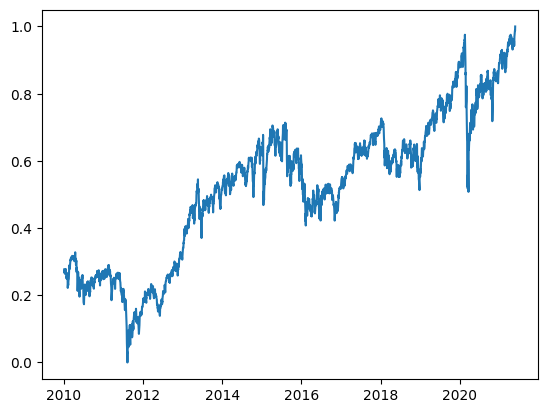

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
#windowed_df = df_to_windowed_df(df,
#                                '2021-03-25',
#                                '2022-03-23',
#                                n=3)

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2010-01-07',
                                '2021-05-28',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2010-01-07,0.277273,0.269407,0.266415,0.265805
1,2010-01-08,0.269407,0.266415,0.265805,0.275229
2,2010-01-11,0.266415,0.265805,0.275229,0.271367
3,2010-01-12,0.265805,0.275229,0.271367,0.263776
4,2010-01-13,0.275229,0.271367,0.263776,0.265683
...,...,...,...,...,...
2847,2021-05-20,0.956169,0.957131,0.942578,0.958688
2848,2021-05-21,0.957131,0.942578,0.958688,0.969767
2849,2021-05-26,0.942578,0.958688,0.969767,0.988332
2850,2021-05-27,0.958688,0.969767,0.988332,0.987055


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2852,), (2852, 3, 1), (2852,))

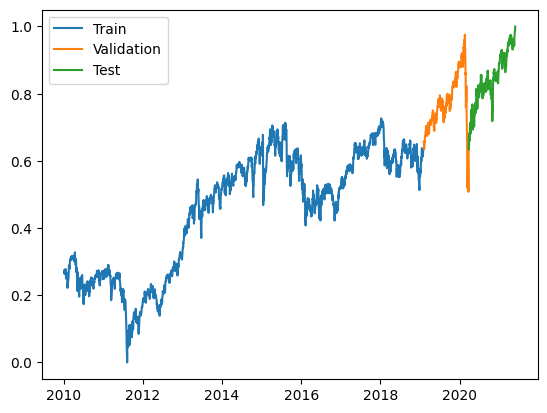

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import save_model

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

model.save("ssmi_model.keras")

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1039 - mean_absolute_error: 0.2568 - val_loss: 0.0075 - val_mean_absolute_error: 0.0825
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0328 - val_loss: 6.3557e-04 - val_mean_absolute_error: 0.0157
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2858e-04 - mean_absolute_error: 0.0110 - val_loss: 5.6759e-04 - val_mean_absolute_error: 0.0143
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5895e-04 - mean_absolute_error: 0.0111 - val_loss: 5.1574e-04 - val_mean_absolute_error: 0.0140
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9953e-04 - mean_absolute_error: 0.0103 - val_loss: 5.2937e-04 - val_mean_absolute_error: 0.0155
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2012e-04 - mean_absolute_error: 0.0107 - val_loss: 5.2147e-04 - val_mean_absolute_error: 0.0151
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1937e-04 

In [ ]:
import pandas as pd
import numpy as np

# Short-term (daily) classification
def classify_daily(dates, predictions, stock_name="SSMI"):
    df_daily = pd.DataFrame({"Stock Name": stock_name, "Dates": dates, "Predicted Prices": predictions})
    df_daily["Mean"] = df_daily["Predicted Prices"].rolling(window=7).mean()
    df_daily["Std Deviation"] = df_daily["Predicted Prices"].rolling(window=7).std()
    df_daily["Classification"] = df_daily.apply(
        lambda row: classify_stock(row["Std Deviation"], row["Mean"]), axis=1
    )
    df_daily.dropna(inplace=True)  # Drop rows with insufficient rolling data
    df_daily.to_csv("daily_classification.csv", index=False)
    return df_daily

# Long-term (monthly) classification
def classify_monthly(dates, predictions, stock_name="SSMI"):
    df_monthly = pd.DataFrame({"Dates": dates, "Predicted Prices": predictions})
    df_monthly["Dates"] = pd.to_datetime(df_monthly["Dates"])
    df_monthly.set_index("Dates", inplace=True)
    df_monthly = df_monthly.resample("M").agg(["mean", "std"])["Predicted Prices"]
    df_monthly.reset_index(inplace=True)
    df_monthly.rename(columns={"mean": "Mean", "std": "Std Deviation"}, inplace=True)
    df_monthly.insert(0, "Stock Name", stock_name)  # Add stock name in the first column
    df_monthly["Classification"] = df_monthly.apply(
        lambda row: classify_stock(row["Std Deviation"], row["Mean"]), axis=1
    )
    df_monthly.to_csv("monthly_classification.csv", index=False)
    return df_monthly


# Classification helper function
def classify_stock(std_dev, mean):
    if mean == 0 or np.isnan(std_dev) or np.isnan(mean):
        return "Unknown"
    volatility = (std_dev / mean) * 100
    if volatility > 10:
        return "Risky"
    elif 5 <= volatility <= 10:
        return "Moderate"
    else:
        return "Conservative"


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


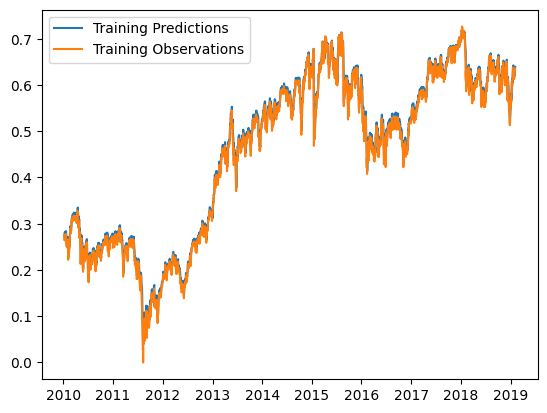

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("ssmi_model.keras")

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


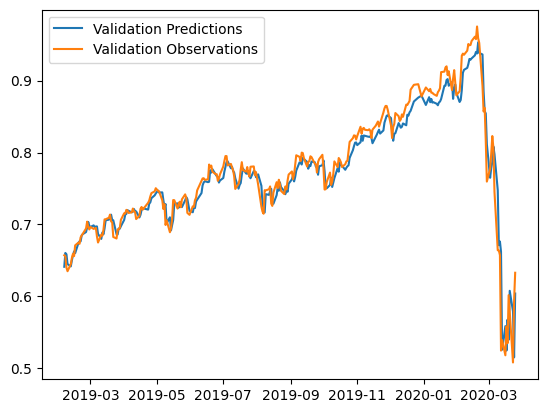

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Daily Classification:
   Stock Name      Dates  Predicted Prices         Mean  Std Deviation  \
6        SSMI 2020-04-03       9304.507812  9163.730887     136.493819   
7        SSMI 2020-04-06       9258.466797  9207.938477     100.808903   
8        SSMI 2020-04-07       9452.476562  9246.330776     135.320408   
9        SSMI 2020-04-08       9487.611328  9314.696429     114.795189   
10       SSMI 2020-04-09       9444.916016  9347.390625     114.609898   

   Classification  
6    Conservative  
7    Conservative  
8    Conservative  
9    Conservative  
10   Conservative  

Monthly Classification:
  Stock Name      Dates          Mean  Std Deviation Classification
0       SSMI 2020-03-31   9089.462891     130.517288   Conservative
1       SSMI 2020-04-30   9517.458984     183.932281   Conservative
2       SSMI 2020-05-31   9656.270508     117.799423   Conservative
3       SSMI 2020-06-30  10023.890625     124.099648   Conservative
4       SS

<ipython-input-56-287f16ea24a7>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_monthly.resample("M").agg(["mean", "std"])["Predicted Prices"]


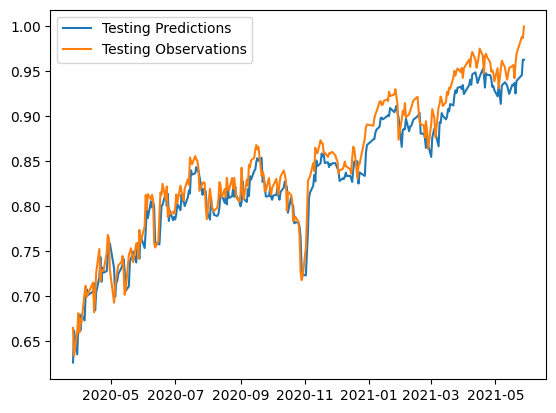

In [ ]:
# Test predictions
test_predictions = model.predict(X_test).flatten()

# Plotting test predictions vs actuals
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# Denormalize test predictions
test_predictions_denorm = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Generate classifications with denormalized predictions
daily_classification = classify_daily(dates_test, test_predictions_denorm)
monthly_classification = classify_monthly(dates_test, test_predictions_denorm)

# Daily classification
#daily_classification = classify_daily(dates_test, test_predictions)

# Monthly classification
#monthly_classification = classify_monthly(dates_test, test_predictions)

# Display the first few rows of each classification
print("Daily Classification:")
print(daily_classification.head())

print("\nMonthly Classification:")
print(monthly_classification.head())


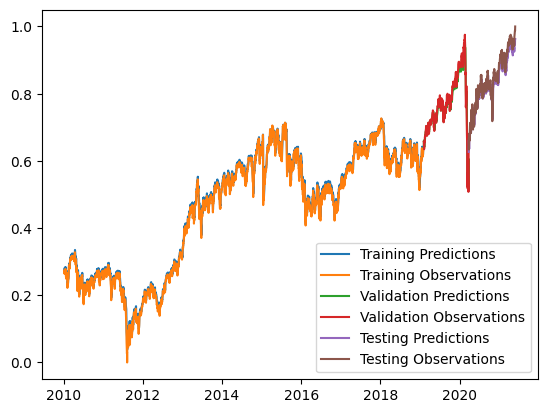

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

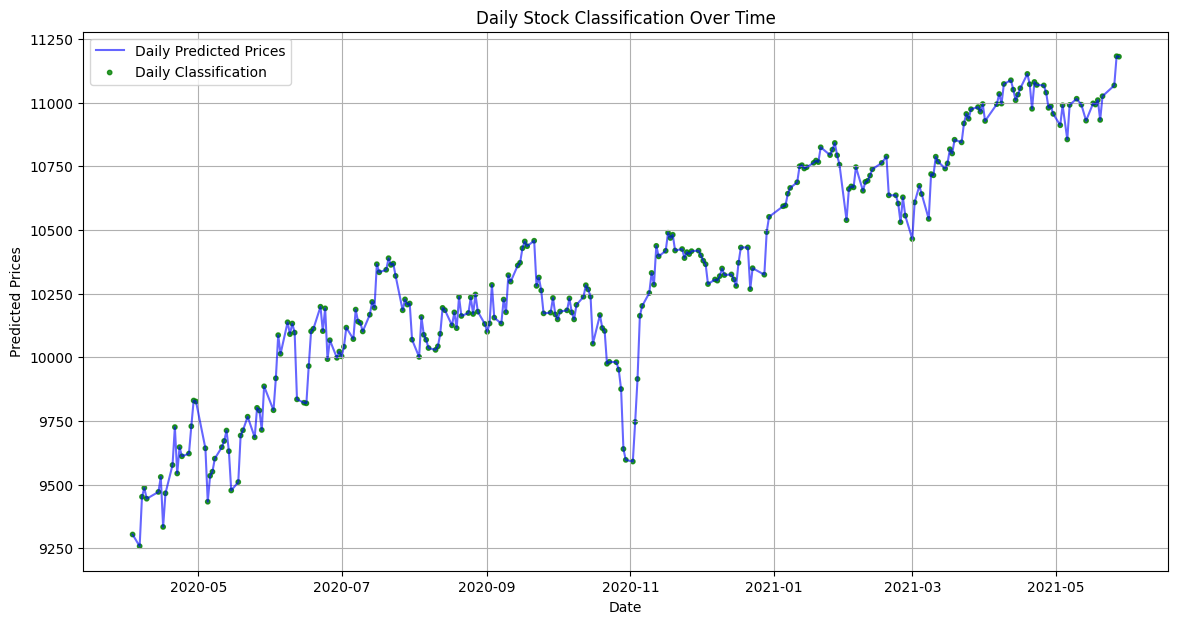

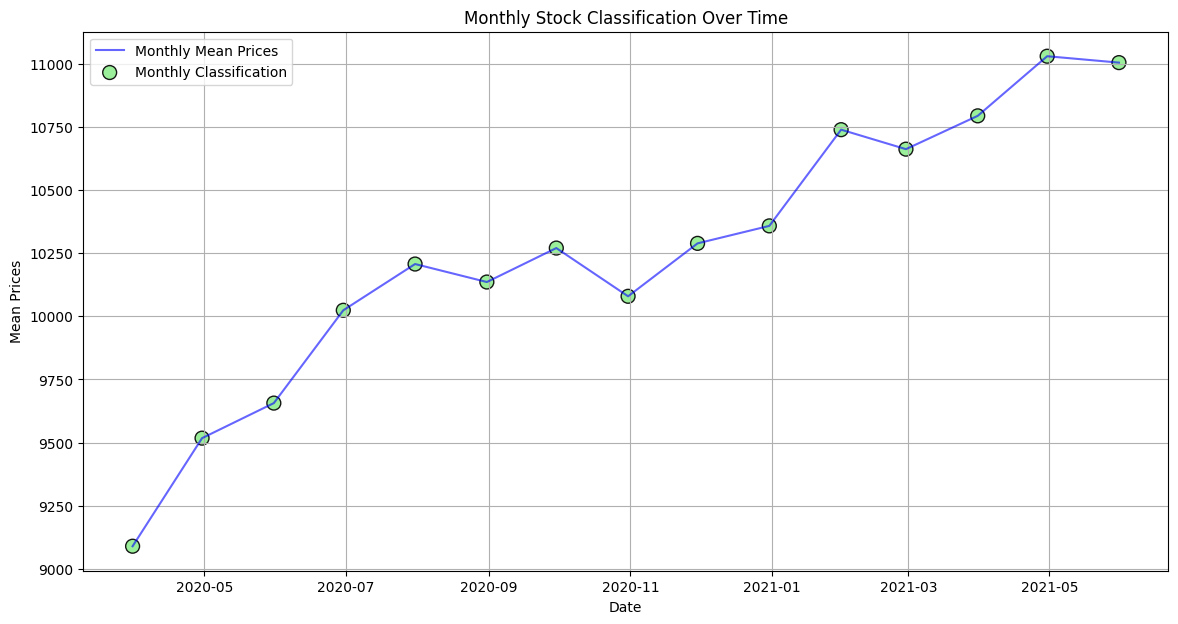

In [ ]:
import matplotlib.pyplot as plt

# Visualize daily classification
def visualize_daily_classifications(daily_df, title="Daily Stock Classification Over Time"):
    classification_map = {"Conservative": 1, "Moderate": 2, "Risky": 3}
    daily_df["Classification Numeric"] = daily_df["Classification"].map(classification_map)
    daily_colors = daily_df["Classification Numeric"].map({1: "green", 2: "orange", 3: "red"})

    plt.figure(figsize=(14, 7))
    plt.plot(daily_df["Dates"], daily_df["Predicted Prices"], label="Daily Predicted Prices", color="blue", alpha=0.6)
    plt.scatter(daily_df["Dates"], daily_df["Predicted Prices"], c=daily_colors, label="Daily Classification", alpha=0.8, s=10)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Predicted Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize monthly classification
def visualize_monthly_classifications(monthly_df, title="Monthly Stock Classification Over Time"):
    classification_map = {"Conservative": 1, "Moderate": 2, "Risky": 3}
    monthly_df["Classification Numeric"] = monthly_df["Classification"].map(classification_map)
    monthly_colors = monthly_df["Classification Numeric"].map({1: "lightgreen", 2: "yellow", 3: "darkred"})

    plt.figure(figsize=(14, 7))
    plt.plot(monthly_df["Dates"], monthly_df["Mean"], label="Monthly Mean Prices", color="blue", alpha=0.6)
    plt.scatter(monthly_df["Dates"], monthly_df["Mean"], c=monthly_colors, label="Monthly Classification", alpha=0.9, s=100, edgecolors="black")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Mean Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_daily_classifications(daily_classification)
visualize_monthly_classifications(monthly_classification)


In [ ]:
### This function is apply classification for future predictions.
### This function was created for classifying future prices and is different from another function above called 'classify_daily'
def classify_future_predictions(future_df, window_size=3):
    """
    Classifies future predicted stock prices based on volatility.

    Parameters:
        future_df: DataFrame containing future dates and predicted prices.
        window_size: Window size for calculating rolling mean and standard deviation.

    Returns:
        Updated DataFrame with Mean, Std Deviation, and Classification columns.
    """
    def classify_stock(std_dev, mean):
        if mean == 0 or np.isnan(std_dev) or np.isnan(mean):
            return "Unknown"
        volatility = (std_dev / mean) * 100
        if volatility > 10:
            return "Risky"
        elif 5 <= volatility <= 10:
            return "Moderate"
        else:
            return "Conservative"

    # Calculate rolling statistics
    future_df["Mean"] = future_df["Predicted Prices"].rolling(window=window_size).mean()
    future_df["Std Deviation"] = future_df["Predicted Prices"].rolling(window=window_size).std()

    # Classify based on volatility
    future_df["Classification"] = future_df.apply(
        lambda row: classify_stock(row["Std Deviation"], row["Mean"]), axis=1
    )

    return future_df


In [ ]:
### This is the function to predict prices 60 days in the future
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def predict_future(model, last_window, scaler, future_days=60):
    """
    Predicts future stock prices recursively for a given number of days.

    Parameters:
        model: Trained LSTM model
        last_window: The last sequence of data (shape: [window_size, features])
        scaler: MinMaxScaler used to normalize the data
        future_days: Number of days to predict into the future

    Returns:
        A DataFrame with predicted future dates and prices.
    """
    predictions = []
    future_dates = pd.date_range(start=df["Date"].iloc[-1], periods=future_days + 1, freq="B")[1:]  # Exclude start date

    # Copy the last window to avoid modifying original data
    current_window = last_window.copy()

    for _ in range(future_days):
        # Predict the next value
        next_prediction = model.predict(np.array([current_window])).flatten()

        # Append the prediction
        predictions.append(next_prediction)

        # Update the window by shifting and adding the new prediction
        current_window[:-1] = current_window[1:]
        current_window[-1] = next_prediction

    # Denormalize predictions
    predictions_denorm = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Create a DataFrame with future dates and predictions
    future_df = pd.DataFrame({
        "Date": future_dates,
        "Predicted Prices": predictions_denorm
    })

    return future_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

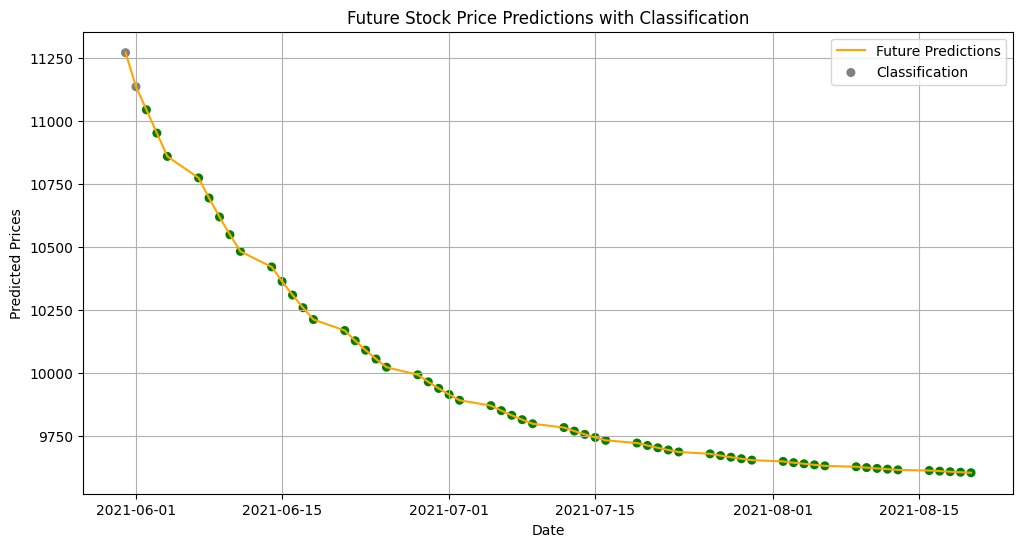

In [ ]:
# Get the last window from the normalized data
window_size = 3
#df.reset_index(inplace=True)

last_window = df["Close"].values[-window_size:].reshape(-1, 1)  # Adjust shape for model input
future_predictions_df = predict_future(model, last_window, scaler, future_days=60)

# Classify the predictions
classified_future_df = classify_future_predictions(future_predictions_df, window_size=3)

# Remove rows with NaN in Classification
classified_future_df = classified_future_df.dropna(subset=["Classification"])

# Map Classification to colors and provide a default for missing values
color_map = {"Conservative": "green", "Moderate": "yellow", "Risky": "red"}
colors = classified_future_df["Classification"].map(color_map).fillna("gray")

# Display the future predictions
print(future_predictions_df)
future_predictions_df.to_csv("future_predictions_ssmi.csv", index=False)

# Plot future predictions with classifications
plt.figure(figsize=(12, 6))
plt.plot(classified_future_df["Date"], classified_future_df["Predicted Prices"], label="Future Predictions", color="orange")
plt.scatter(classified_future_df["Date"], classified_future_df["Predicted Prices"],
            c=colors, label="Classification", s=30)
plt.title("Future Stock Price Predictions with Classification")
plt.xlabel("Date")
plt.ylabel("Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
'''import numpy as np

# Save X_train to a file
np.save("X_train.npy", X_train)

# Load it back later
X_train = np.load("X_train.npy")
'''

In [ ]:
'''
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

# Initialize the last window with the final training data sequence
last_window = X_train[-1].copy()

for target_date in recursive_dates:
    # Make a prediction using the current last window
    next_prediction = model.predict(np.array([last_window])).flatten()

    # Optionally denormalize the prediction (if required)
    # next_prediction = scaler.inverse_transform(next_prediction.reshape(-1, 1)).flatten()

    # Append the prediction to the list
    recursive_predictions.append(next_prediction)

    # Shift the window and update with the new prediction
    last_window[:-1] = last_window[1:]  # Shift window left
    last_window[-1] = next_prediction   # Add the new prediction
'''

In [ ]:
'''
plt.plot(recursive_dates, recursive_predictions, label="Recursive Predictions")
plt.legend()
plt.show()
'''

In [ ]:
'''
recursive_predictions_denorm = scaler.inverse_transform(np.array(recursive_predictions).reshape(-1, 1)).flatten()
df_recursive_daily = classify_daily(recursive_dates, recursive_predictions_denorm)
df_recursive_monthly = classify_monthly(recursive_dates, recursive_predictions_denorm)
'''